# Load data

In [203]:
import pandas as pd
import numpy as np
import joblib
from model_auditing.data_quality import *
from model_auditing.model_auditor import *
from model_auditing.preprocessing_tools import *
from model_auditing.risks import *

In [204]:
# load data from file
X_train = pd.read_csv('./regression_data/X_train.csv', sep=';', index_col=0)
y_train = pd.read_csv('./regression_data/y_train.csv', sep=';', index_col=0)
X_test = pd.read_csv('./regression_data/X_test.csv', sep=';', index_col=0)
y_test = pd.read_csv('./regression_data/y_test.csv', sep=';', index_col=0)
df = pd.read_csv('./regression_data/all_data.csv', sep=';', index_col=0)
model1 = joblib.load('./regression_data/lr_model1.joblib')

In [205]:
# properly encode output variables
y_name = 'mpg'
model_pred = 'BSTR_pred'
df.rename(columns = {y_name:'Y', model_pred: 'model_pred'}, inplace = True)

In [206]:
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Y,model_pred
64,8,318.00,150,4135,13.50,72,1,15.00,14.19
55,4,97.00,60,1834,19.00,71,2,27.00,29.22
317,4,97.00,78,2188,15.80,80,2,34.30,33.28
102,4,97.00,46,1950,21.00,73,2,26.00,25.37
358,4,120.00,74,2635,18.30,81,3,31.60,32.12


In [207]:
# encode categorical output variable
to_category(df, 'model year', 'origin', 'cylinders')
column_encoder(X_train, df)# Apply same encoding to test and training data
column_encoder(X_test, X_train)

In [208]:
# eliminate weird values (specific to this dataset)
# eliminate weird values (specific to this dataset)

def remove_weird(df, val):
    id = df[df.isin([val]).any(1)].index
    df.drop(id, axis=0, inplace=True)

remove_weird(df, '?')
remove_weird(X_train, '?')
remove_weird(X_test, '?')

In [209]:
df.dropna(inplace=True)
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [210]:
y_train = y_train.loc[X_train.index,:]
y_test = y_test.loc[X_test.index, :]

# Risks

## High level risk assesment

In [211]:
from model_auditing.preprocessing_tools import *
from model_auditing.risks import *
from model_auditing.model_auditor import *
from model_auditing.data_quality import *

In [212]:
# calculate residuals for DF
calculate_residuals(df, df['Y'], df['model_pred'], task='R')

In [213]:
# check that it worked
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Y,model_pred,res,abs_res,mape
64,8,318.00,150,4135,13.50,72,1,15.00,14.19,0.81,0.81,0.05
55,4,97.00,60,1834,19.00,71,2,27.00,29.22,-2.22,2.22,0.08
317,4,97.00,78,2188,15.80,80,2,34.30,33.28,1.02,1.02,0.03
102,4,97.00,46,1950,21.00,73,2,26.00,25.37,0.63,0.63,0.02
358,4,120.00,74,2635,18.30,81,3,31.60,32.12,-0.52,0.52,0.02


In [214]:
# plot residuals - prioridad 3
# qq_plots(df, 'res', 'abs_res', 'mape')

## KDE

In [215]:
class KDE:
    """
    Class used for applying KDE analysis

    INPUTS:
    -res: Pandas DataFrame, shape=(n_samples, 1)
            residual data to be plotted.

    -cutoff_value: int or float
            initial value for defining probability area of interest within the plot

    -x_end: int or float
            final value for defining probability area of interest within the plot
    """
    def __init__(self, res, cutoff_value, x_end):
        self.res = res
        self.cutoff_value = cutoff_value
        self.x_end = x_end
        self.kd = None
        self.probability = None
        

    def plot_prob_density(self, plotname, bandwidth=0.01, nbins=10):
        """
        Function used to calculate and plot PDF distribution using KDE

        Adapted from: https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab

        INPUTS:
        
        -plot_name: string
            col of the type of residual to be plotted. Used for labelling plot
        
        -bandwidth: int
            bandwidth used for KDE. Default value is 0.01

        -nbins: int
            number of bins for the histogram. Default value is 10

        """
        from sklearn.neighbors import KernelDensity
        import gc
        
        plt.rcParams['axes.facecolor'] = 'white'
        fig, ax = plt.subplots(figsize = (15, 7))
        # plt.figure(figsize = (15, 7))
        # plt.grid(visible=False)
        ax.grid(visible=False)

        x = np.linspace(self.res.min(), self.res.max(), 1000)[:, np.newaxis]

        # Plot the data using a normalized histogram
    
        plt.hist(self.res, bins=nbins, density=True, label=plotname, color='#92c5de', alpha=1)

        # Do kernel density estimation
        kd = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(self.res.values[:, np.newaxis])
        self.kd = kd

        # Plot the estimated densty
        kd_probs = np.exp(kd.score_samples(x))

        plt.plot(x, kd_probs, color='black')

        plt.axvline(x=self.cutoff_value,color='black',linestyle='dashed')
        plt.axvline(x=self.x_end,color='black',linestyle='dashed')
        plt.gca().spines['bottom'].set_color('black') 
        plt.gca().spines['left'].set_color('black') 
        plt.gca().spines['left'].set_linewidth(1.8) 
        plt.gca().spines['bottom'].set_linewidth(1.8) 

        # Show the plots
        plt.xlabel("Expected Error (%)", fontsize=15)
        plt.ylabel('Probability Distribution', fontsize=15)
        plt.legend(loc='upper right', fontsize=12)
        from matplotlib.ticker import PercentFormatter
        fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
        ax.xaxis.set_major_formatter(fmt_percent)
        plt.show()
        gc.collect()

    def get_probability(self):
        """
        Function used to calculate probability in a defined region
        from a fitted KDE distribution using integrals.

        Adapted from: https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab

        RETURNS:
        -probability: float
            probability of a value being between cutoff_value and x_end
        
        """
        
        # Number of evaluation points 
        N = 100  
        # Step size                                    
        step = (self.x_end - self.cutoff_value) / (N - 1)

        # Generate values in the range
        x = np.linspace(self.cutoff_value, self.x_end, N)[:, np.newaxis]  
        # Get PDF values for each x
        kd_vals = np.exp(self.kd.score_samples(x)) 
        # Approximate the integral of the PDF 
        probability = np.sum(kd_vals * step) 
        self.probability = probability

        return probability

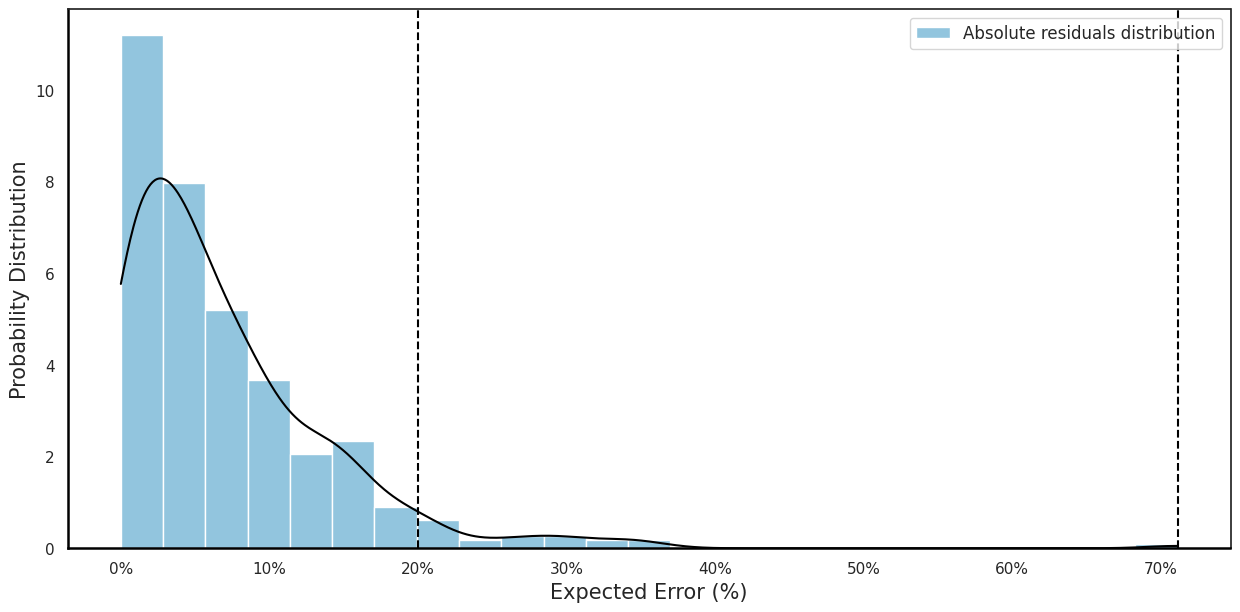

In [216]:
# prioridad 1 - estilo bayesianx
# define cuotoff value for calculating probabilities
# cutoff_value = np.percentile(df['mape'], 90)
cutoff_value = 0.2

# define end value for calculating probabilities
x_end = df['mape'].max()

# instantiate class

kde = KDE(res=df["mape"], cutoff_value=cutoff_value, x_end=x_end)

# plot KDE

kde_plot = kde.plot_prob_density(plotname="Absolute residuals distribution",
                                 bandwidth=0.02,
                                 nbins=25)

In [217]:
# calculate probabilities
prob = kde.get_probability()
print(prob)

0.05222588289474305


## Error distribution

In [218]:
def plot_residuals(df, *columns):
    """
    Plots residuals for specified datasets

    INPUTS:
    
    -df: pd.DataFrame
        DataFrame containing the residuals to be plotted
    
    -*columns:
        Names of the residual columns to be plotted

    """
    sns.set()
    # Set axes
    fig, axs = plt.subplots(nrows=1, ncols=len(columns),
                            figsize=(15,7), sharex=False, 
                            sharey=False)
    plt.tight_layout()
    # Set different colors for different plots
    titles = ["Residual", "Absolute Residuals", "MAPE"]
    i = 0
    for col, ax in zip(columns, axs.ravel()):
        # plot residuals distribution
        plot = sns.histplot(data=df, x=col, ax=ax, 
                           bins=20, color="blue", 
                           edgecolor="black", 
                           kde=True, line_kws={'lw': 2})
        plot.lines[0].set_color('darkred')
        plot.set_title(titles[i], fontsize=20)
        plot.set_xlabel(titles[i], fontsize=15)
        plot.set_ylabel('')
        i+=1
            
    plt.show()

In [219]:
# todos color azul - prioridad 2
# plot_residuals(df, "res", "abs_res", 'mape')

In [220]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import PercentFormatter

# # Create data
# mape = [7.4214] # MAPE values
# var = [0.5140234413965081] # Var values
# bias = [6.9073765586034925] # Bias values

# # Create figure and axis objects
# fig, ax = plt.subplots(figsize=(7,8))
# ax.grid(b=False)
# ax.set_facecolor("#E2E5E8")

# # Set width of bars
# width = 0.2

# # Create stacked bars
# ax.bar(range(1), var, width, label='Var', color="#92c5de")
# ax.bar(range(1), bias, width, bottom=var, label='Bias', color="#2F94B3")

# ax.text(0, float(var[0]/2), "{:.2f}%".format(var[0]), ha='center', va='center')
# ax.text(0, float(var[0]/2) + float(bias[0]/2), "{:.2f}%".format(bias[0]), ha='center', va='center')
# ax.text(0, float(mape[0]) + 0.1, "{:.2f}%".format(mape[0]), ha='center', va='center')

# # Add labels and legend
# ax.set_ylabel('MAPE')
# ax.set_xticks(range(len(mape)))
# ax.set_xticklabels(['MAPE value'])
# ax.set_ylabel("Percentage (%)")
# ax.yaxis.set_major_formatter(PercentFormatter())
# ax.legend()

# # Show plot
# plt.show()


## Feature importance for error

## Regression

In [221]:
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Y,model_pred,res,abs_res,mape
64,8,318.00,150,4135,13.50,72,1,15.00,14.19,0.81,0.81,0.05
55,4,97.00,60,1834,19.00,71,2,27.00,29.22,-2.22,2.22,0.08
317,4,97.00,78,2188,15.80,80,2,34.30,33.28,1.02,1.02,0.03
102,4,97.00,46,1950,21.00,73,2,26.00,25.37,0.63,0.63,0.02
358,4,120.00,74,2635,18.30,81,3,31.60,32.12,-0.52,0.52,0.02


In [222]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
64,8,318.00,150,4135,13.50,72,1
55,4,97.00,60,1834,19.00,71,2
317,4,97.00,78,2188,15.80,80,2
102,4,97.00,46,1950,21.00,73,2
358,4,120.00,74,2635,18.30,81,3


In [223]:
# Define input and output matrices
INPUTS = X_train.columns.tolist()
OUTPUT = 'res'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X_res = df[INPUTS]
y_res = df[OUTPUT]

# Split
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res,
                                                    random_state=2023) #seed for replication
X_train_res.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
218,4,79.00,58,1825,18.60,77,2
74,8,302.00,140,4294,16.00,72,1
188,8,318.00,150,4190,13.00,76,1
29,4,97.00,88,2130,14.50,71,3
271,4,156.00,105,2745,16.70,78,1


In [224]:
## Inputs of the model. Change accordingly to perform variable selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb

INPUTS_BST_NUM = X_train_res.select_dtypes(include=['int64','float64']).columns.tolist()
INPUTS_BST_CAT = X_train_res.select_dtypes(include=['category']).columns.tolist()
INPUTS_BST = INPUTS_BST_NUM + INPUTS_BST_CAT

numeric_transformer = Pipeline(steps=[('scaler',RobustScaler())]) # Don't apply if vars already standarized

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]) 
# categorical_transformer = Pipeline(steps=[('onehot', LabelEncoder())]) 


preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_BST_NUM),
        ('cat', categorical_transformer, INPUTS_BST_CAT)
        ])

BSTR = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                        ('BSTR',xgb.XGBRegressor(random_state=2022,
                                                 objective='reg:squarederror',
                                                 max_depth=5,
                                                 booster='gbtree',
                                                 n_estimators=200,
                                                 learning_rate=0.05))])


BSTR.fit(X_train_res, y_train_res) # Search in grid

Pipeline(steps=[('Prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['displacement', 'weight',
                                                   'acceleration']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cylinders', 'model year',
                                                   'origin'])])),
                ('BSTR',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=2022, ...))])

In [225]:
# from sklearn.linear_model import LinearRegression

# lr = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
#                         ('LR',LinearRegression())])


# lr.fit(X_train_res, y_train_res) # Search in grid

In [226]:
# from sklearn.model_selection import RepeatedKFold
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(BSTR, X_train_res, y_train_res, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [227]:
y_train_res_pred = BSTR.predict(X_train_res)
y_test_res_pred = BSTR.predict(X_test_res)

# y_train_res_pred = lr.predict(X_train_res)
# y_test_res_pred = lr.predict(X_test_res)

In [228]:
#Training and test MAE - Mean Absolute error FOR M2
print('Training MAE:',mean_absolute_error(y_train_res, y_train_res_pred))
print('Test MAE:',mean_absolute_error(y_test_res,y_test_res_pred))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(y_train_res, y_train_res_pred)))
print('Test RMSE:',math.sqrt(mean_squared_error(y_test_res,y_test_res_pred)))
#Training and test r^2 
print('Training R2:',r2_score(y_train_res, y_train_res_pred))
print('Test R2:',r2_score(y_test_res, y_test_res_pred))

Training MAE: 0.5727808357195849
Test MAE: 1.7701698724816375
Training RMSE: 0.7713331786569375
Test RMSE: 2.350072389418868
Training R2: 0.895168016474313
Test R2: -0.2346242283573019


In [229]:
print(np.mean(y_test_res))
np.mean(y_test_res_pred)

0.07021305575137941


-0.08742095

In [230]:
class SHAPEvaluator:
    """
    Class for using SHAP on model
    """
    def __init__(self, X_enc, model):
        self.X_enc = X_enc
        self.model = model
        self.shap_values = None
        self.feature_importance_table = None
        self.apply_shap()

    def apply_shap(self):
        """
        Fit SHAP evaluator to model
        """
        # instantiate explainer
        try:
            explainer = shap.TreeExplainer(self.model)
        except:
            explainer = shap.LinearExplainer(model=self.model, masker=self.X_enc)
        # calculate shap_values
        shap_values = explainer(self.X_enc)
        self.shap_values = shap_values

    def summary_plot(self):
        # summary plot 

        import matplotlib.pyplot as plt
        import matplotlib.colors as colors
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.grid(visible=False)

        color1 = '#444444'
        color2 = '#2F94B3'
        
        # Create a custom colormap that is a gradient between the two colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)])

        # plot_size=(12,5)
        shap.summary_plot(self.shap_values, self.X_enc, cmap = cmap, show = False) 
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)
        plt.xlabel("Impact on Error (-1, 1)", fontsize = 15) 
        plt.show()
    
    def scatter_plots(self):
        # scatter plots
        shap.plots.scatter(self.shap_values[:, self.shap_values.abs.mean(0).argsort[:-4:-1]])

    def feature_importance(self):
        """
        Get variables order by feature importance
        """
        # create DataFrame with shap values
        df_shap_values = pd.DataFrame(data=self.shap_values.values,
                                      columns=self.X_enc.columns)
        df_feature_importance = pd.DataFrame(columns=['feature','importance'])

        # calculate absolute value of feature importance
        for col in df_shap_values.columns:
            importance = df_shap_values[col].abs().mean()
            df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
        
        # sort data by importance of features
        df_feature_importance = df_feature_importance.sort_values('importance', ascending=False)
        self.feature_importance_table = df_feature_importance

        return df_feature_importance
    
    def waterfall(self, n_sample):
        import matplotlib
        import matplotlib.pyplot as plt
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.figure(figsize=(21, 9)) 
        plt.grid(visible=False)
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)

        # Default SHAP colors
        default_pos_color = "#ff0051"
        default_neg_color = "#008bfb"
        # Custom colors
        positive_color = "#2F94B3" 
        negative_color = "#444444"

        shap.plots.bar(self.shap_values[n_sample], show = False)
        # Change the colormap of the artists
        for fc in plt.gcf().get_children():
            # Ignore last Rectangle
            for fcc in fc.get_children()[:-1]:
                if (isinstance(fcc, matplotlib.patches.Rectangle)):
                    if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                        fcc.set_facecolor(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                        fcc.set_color(negative_color)
                elif (isinstance(fcc, plt.Text)):
                    if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                        fcc.set_color(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                        fcc.set_color(negative_color)
        plt.show()

    def waterfall2(self, n_sample):
        import matplotlib
        import matplotlib.pyplot as plt
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.figure(figsize=(21, 9)) 
        plt.grid(visible=False)
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)

        # Default SHAP colors
        default_pos_color = "#ff0051"
        default_neg_color = "#008bfb"
        # Custom colors
        positive_color = "#2F94B3" 
        negative_color = "#444444"

        shap.plots.waterfall(self.shap_values[n_sample], show = False)
        # Change the colormap of the artists
        for fc in plt.gcf().get_children():
            for fcc in fc.get_children():
                if (isinstance(fcc, matplotlib.patches.FancyArrow)):
                    if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                        fcc.set_facecolor(positive_color)
                        fcc.set_edgecolor(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                        fcc.set_color(negative_color)
                        fcc.set_edgecolor(negative_color)

                elif (isinstance(fcc, plt.Text)):
                    if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                        fcc.set_color(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                        fcc.set_color(negative_color)
        plt.show()
    
    def plot_feature_importance(self, y):
        import matplotlib
        # get top features ordered by importance
        default_pos_color = "#ff0051" 
        default_neg_color = "#008bfb" 
        # Custom colors 
        positive_color = "#2F94B3" 
        negative_color = "#444444" 
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.figure(figsize=(21, 9)) 
        plt.grid(visible=False) 
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)
        shap.plots.bar(self.shap_values, max_display = 10, show = False) 
        # Change the colormap of the artists 
        for fc in plt.gcf().get_children(): 
            for fcc in fc.get_children()[:-1]: 
                if (isinstance(fcc, matplotlib.patches.Rectangle)): 
                    if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color): 
                        fcc.set_facecolor(positive_color)
                        
                    elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color): 
                        fcc.set_color(negative_color) 
                    
                elif (isinstance(fcc, plt.Text)): 
                    if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color): 
                        fcc.set_color(positive_color)

                    elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color): 
                        fcc.set_color(negative_color) 

        plt.title("Feature Importance", x = 0.45, y = 1.01, fontsize = 15, style='italic', pad = 2 )
        plt.show()


In [231]:
enc = fit_encoder(X_train)
X_train_proc = enc.transform(X_train)
X_test_proc = enc.transform(X_test)

In [232]:
# prioridad 1 - change colors
explainer = SHAPEvaluator(X_train_proc, BSTR[-1])
# prioridad 1 - feature importance (top 5)
# a = explainer.feature_importance()

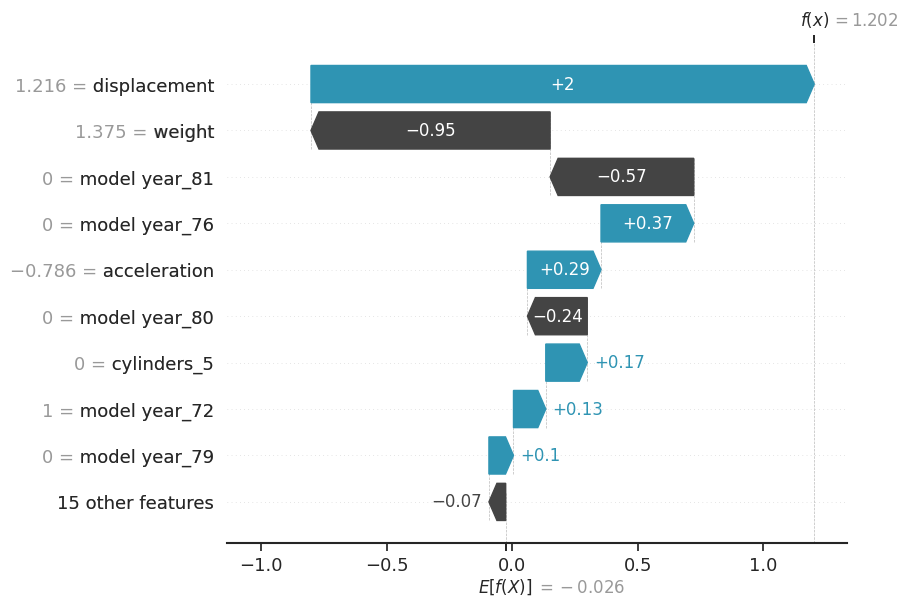

In [233]:
explainer.waterfall2(0)

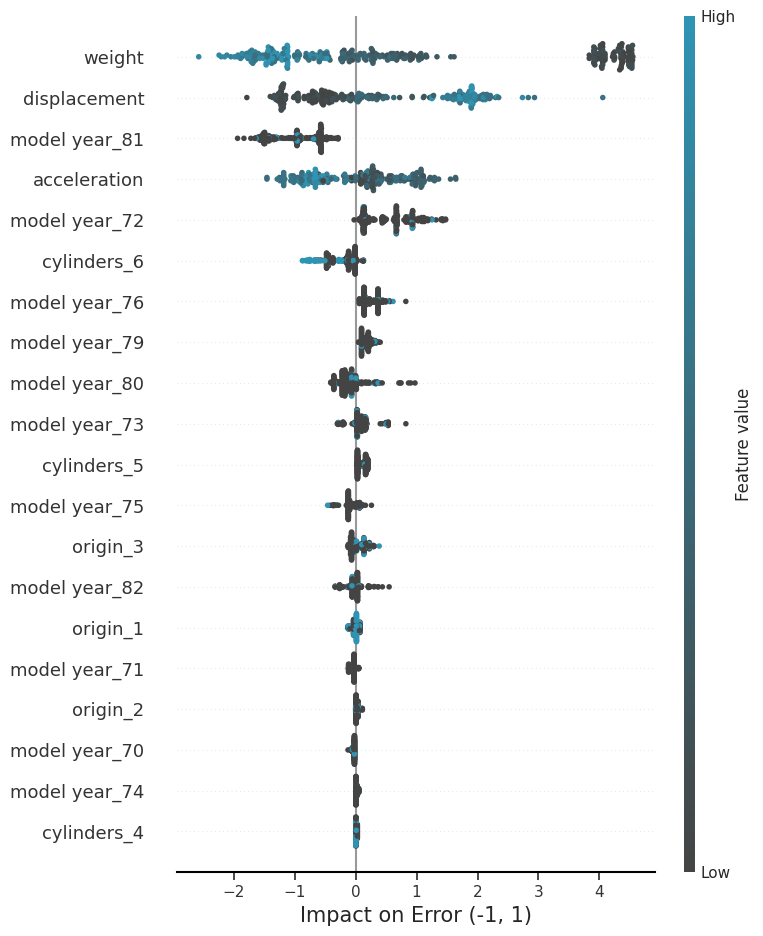

In [234]:
explainer.summary_plot()

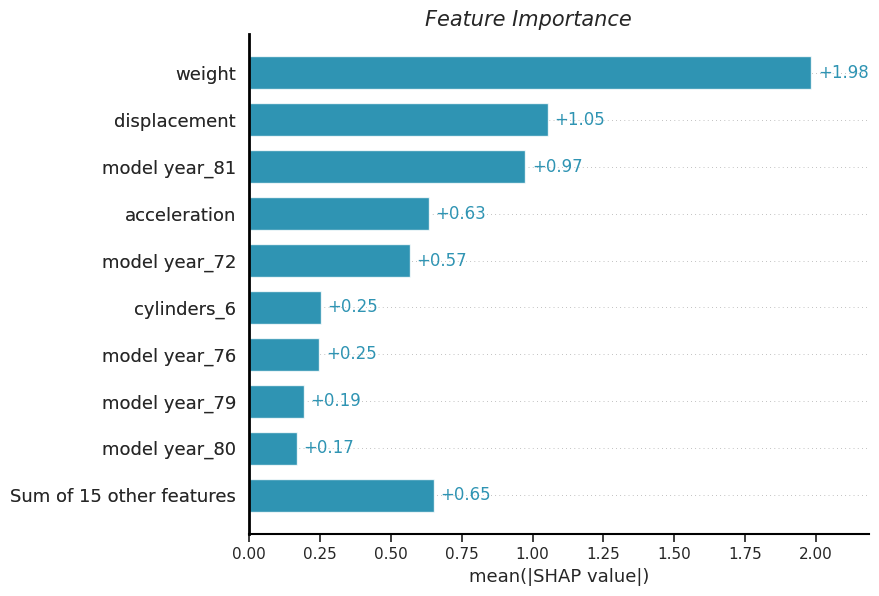

In [235]:
explainer.plot_feature_importance(y=y_train)

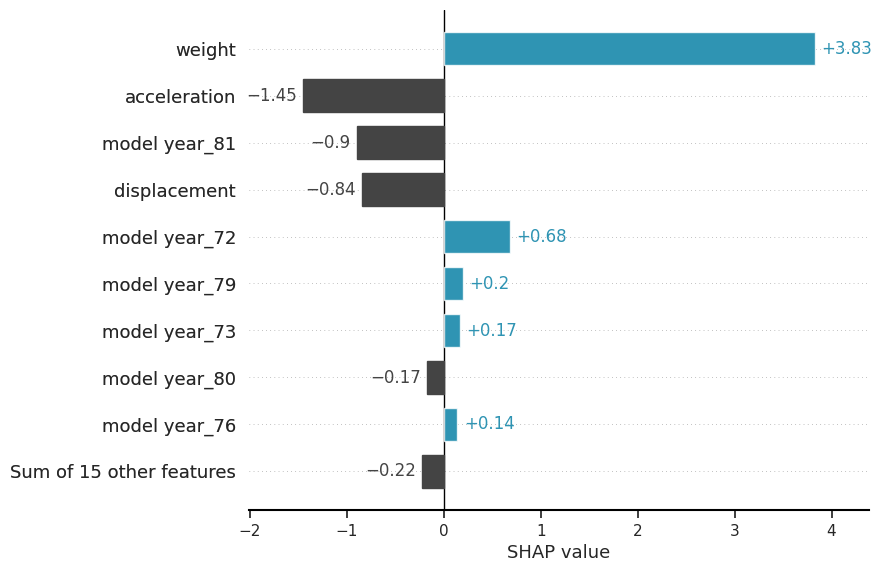

In [236]:
explainer.waterfall(n_sample=2)

## Classification

In [237]:
# define new output
df['is_high'] = [1 if x >= np.percentile(np.abs(df['res']), 90) else 0 for x in df['res']]
df['is_high'] = df['is_high'].astype('category')
# drop prediction variables from table
try:
    df.drop(['model_pred'], axis=1, inplace=True)
except:
    pass

In [238]:
# define features
features = df.columns[:-5].tolist()

# split data
X_train, X_test, y_train, y_test = split_data(df, features, output='is_high', test_size=0.2)

In [239]:
# fix class imbalance
fix_class_imbalance(X_train, y_train)

(    cylinders  displacement horsepower  weight  acceleration model year origin
 0           4        135.00      84.00    2525         16.00         82      1
 1           6        171.00      97.00    2984         14.50         75      1
 2           6        173.00     115.00    2595         11.30         79      1
 3           4         97.00      75.00    2155         16.40         76      3
 4           4         79.00      70.00    2074         19.50         71      2
 ..        ...           ...        ...     ...           ...        ...    ...
 585         4         88.90      62.20    2050         17.33         80      3
 586         4         90.76      68.15    2120         15.02         78      3
 587         4         95.53      65.18    1833         15.16         80      3
 588         4         89.38      63.35    2065         16.80         78      3
 589         4         85.60      64.46    2095         18.05         79      3
 
 [590 rows x 7 columns],
 array([0, 0,

In [240]:
# preprocess features
enc = fit_encoder(X_train)
X_train_proc = enc.transform(X_train)
X_test_proc = enc.transform(X_test)

In [241]:
from xgboost import XGBClassifier
BSTC = XGBClassifier(random_state=2022,
                          objective='binary:logistic',
                          max_depth=5,
                          n_estimators=300,
                          learning_rate=0.01)

BSTC.fit(X_train_proc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=2022, ...)

In [242]:
# make predictions using classifier
y_train_pred = BSTC.predict(X_train_proc)
y_test_pred = BSTC.predict(X_test_proc)

In [243]:
# Analyze CV accuracy
print("CV accuracy is")
cross_val_score(BSTC, X_train_proc, y_train, cv=3, scoring='accuracy').mean()

CV accuracy is


0.936080586080586

In [244]:
print("----- TRAINING CONFUSION MATRIX -----")
create_CM(y_train, y_train_pred)

----- TRAINING CONFUSION MATRIX -----
Accuracy: 0.95
Balanced_accuracy: 0.53
Sensitivity: 1.00
Specificity: 0.06
Precision: 1.00


{'Accuracy': 0.9456869009584664,
 'Balanced_accuracy': 0.5277777777777778,
 'Sensitivity': 1.0,
 'Specificity': 0.06,
 'Precision': 1.0}

In [245]:
print("----- TESTING CONFUSION MATRIX -----")
create_CM(y_test, y_test_pred)

----- TESTING CONFUSION MATRIX -----
Accuracy: 0.95
Balanced_accuracy: 0.50
Sensitivity: 1.00
Specificity: 0.00
Precision: 0.00


{'Accuracy': 0.9493670886075949,
 'Balanced_accuracy': 0.5,
 'Sensitivity': 1.0,
 'Specificity': 0.0,
 'Precision': 0.0}

## SHAP

In [246]:
class SHAPEvaluator:
    """
    Class for using SHAP on model
    """
    def __init__(self, X_enc, model):
        self.X_enc = X_enc
        self.model = model
        self.shap_values = None
        self.feature_importance_table = None
        self.apply_shap()

    def apply_shap(self):
        """
        Fit SHAP evaluator to model
        """
        # instantiate explainer
        try:
            explainer = shap.TreeExplainer(self.model)
        except:
            explainer = shap.LinearExplainer(model=self.model, masker=self.X_enc)
        # calculate shap_values
        shap_values = explainer(self.X_enc)
        self.shap_values = shap_values

    def summary_plot(self):
        # summary plot 

        import matplotlib.pyplot as plt
        import matplotlib.colors as colors
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.grid(visible=False)

        color1 = '#444444'
        color2 = '#2F94B3'
        
        # Create a custom colormap that is a gradient between the two colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)])

        # plot_size=(12,5)
        shap.summary_plot(self.shap_values, self.X_enc, cmap = cmap, show = False) 
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)
        plt.xlabel("Impact on Error (-1, 1)", fontsize = 15) 
        plt.show()
    
    def scatter_plots(self):
        # scatter plots
        shap.plots.scatter(self.shap_values[:, self.shap_values.abs.mean(0).argsort[:-4:-1]])

    def feature_importance(self):
        """
        Get variables order by feature importance
        """
        # create DataFrame with shap values
        df_shap_values = pd.DataFrame(data=self.shap_values.values,
                                      columns=self.X_enc.columns)
        df_feature_importance = pd.DataFrame(columns=['feature','importance'])

        # calculate absolute value of feature importance
        for col in df_shap_values.columns:
            importance = df_shap_values[col].abs().mean()
            df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
        
        # sort data by importance of features
        df_feature_importance = df_feature_importance.sort_values('importance', ascending=False)
        self.feature_importance_table = df_feature_importance

        return df_feature_importance
    
    def waterfall(self, n_sample):
        import matplotlib
        import matplotlib.pyplot as plt
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.figure(figsize=(21, 9)) 
        plt.grid(visible=False)
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)

        # Default SHAP colors
        default_pos_color = "#ff0051"
        default_neg_color = "#008bfb"
        # Custom colors
        positive_color = "#2F94B3" 
        negative_color = "#444444"

        shap.plots.bar(self.shap_values[n_sample], show = False)
        # Change the colormap of the artists
        for fc in plt.gcf().get_children():
            # Ignore last Rectangle
            for fcc in fc.get_children()[:-1]:
                if (isinstance(fcc, matplotlib.patches.Rectangle)):
                    if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                        fcc.set_facecolor(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                        fcc.set_color(negative_color)
                elif (isinstance(fcc, plt.Text)):
                    if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                        fcc.set_color(positive_color)
                    elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                        fcc.set_color(negative_color)
        plt.show()
    
    def plot_feature_importance(self, y):
        import matplotlib
        # get top features ordered by importance
        default_pos_color = "#ff0051" 
        default_neg_color = "#008bfb" 
        # Custom colors 
        positive_color = "#2F94B3" 
        negative_color = "#444444" 
        plt.rcParams['axes.facecolor'] = 'white' 
        plt.figure(figsize=(21, 9)) 
        plt.grid(visible=False) 
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_color('black')
        plt.gca().spines['left'].set_linewidth(2)
        shap.plots.bar(self.shap_values, max_display = 10, show = False) 
        # Change the colormap of the artists 
        for fc in plt.gcf().get_children(): 
            for fcc in fc.get_children()[:-1]: 
                if (isinstance(fcc, matplotlib.patches.Rectangle)): 
                    if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color): 
                        fcc.set_facecolor(positive_color)
                        
                    elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color): 
                        fcc.set_color(negative_color) 
                    
                elif (isinstance(fcc, plt.Text)): 
                    if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color): 
                        fcc.set_color(positive_color)

                    elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color): 
                        fcc.set_color(negative_color) 

        plt.title("Feature Importance", x = 0.45, y = 1.01, fontsize = 15, style='italic', pad = 2 )
        plt.show()


In [247]:
# prioridad 1 - change colors
explainer = SHAPEvaluator(X_train_proc, BSTC)
# prioridad 1 - feature importance (top 5)
a = explainer.feature_importance()

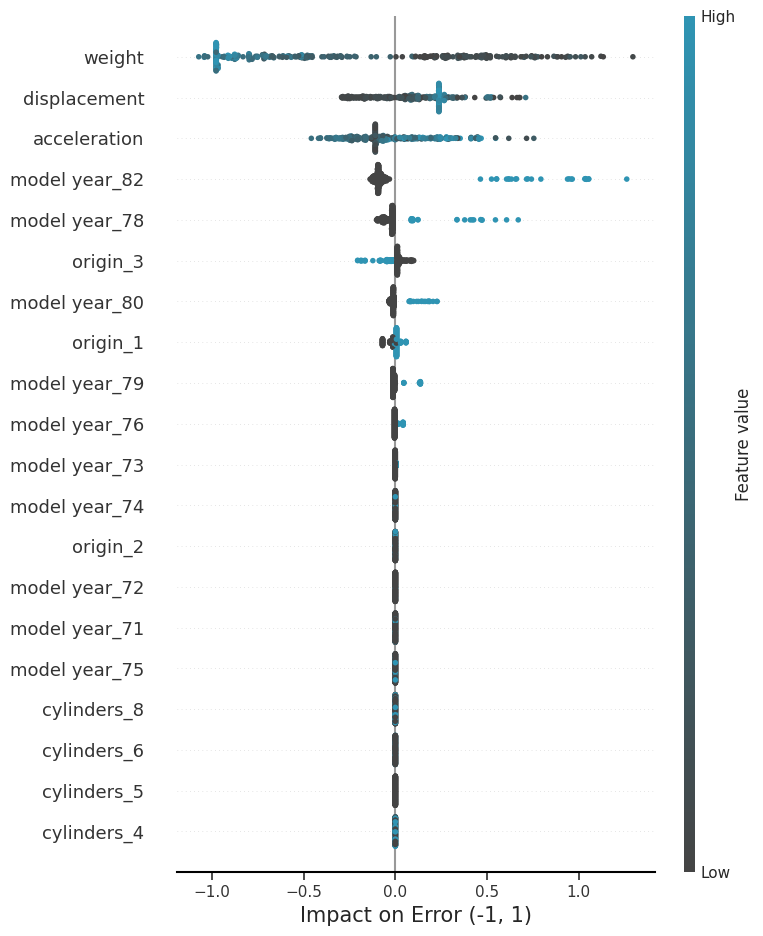

In [248]:
explainer.summary_plot()

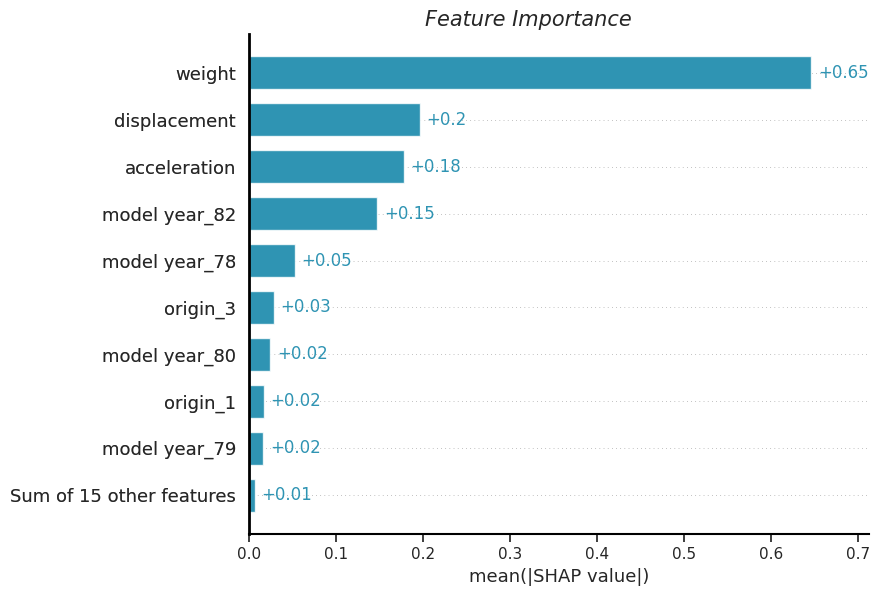

In [249]:
explainer.plot_feature_importance(y=y_train)

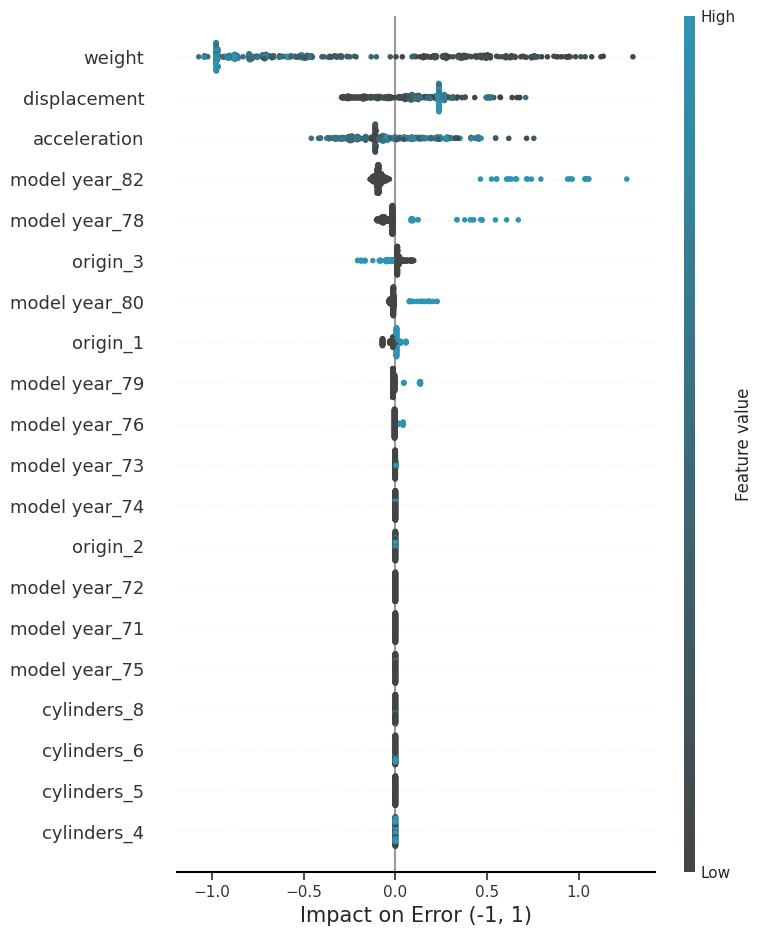

In [250]:
explainer.summary_plot()

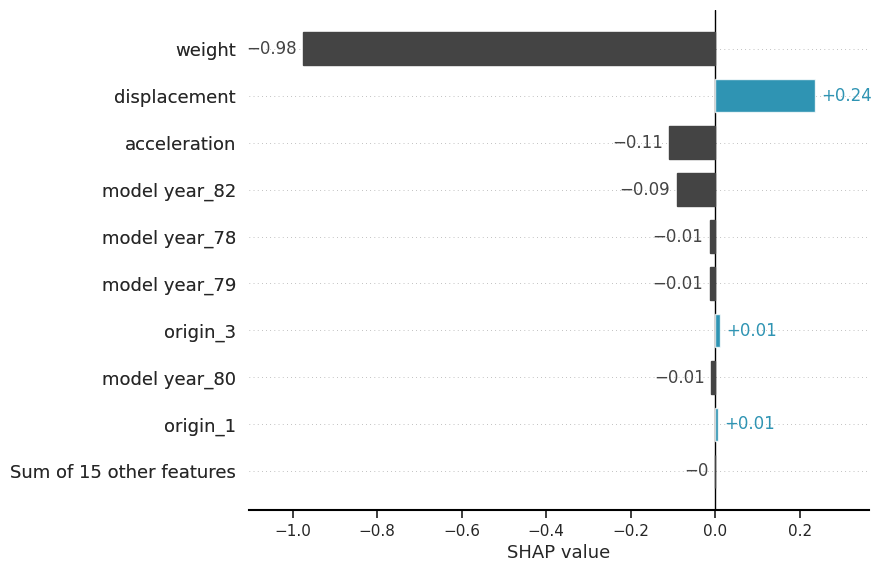

In [251]:
explainer.waterfall(n_sample=45) # observation number

## SHAP over original model

In [252]:
# prepare data for SHAP
shapcols = X_train.columns.values.tolist()
shap_df = df[shapcols]
X_enc = model1['Prep'].transform(shap_df)

In [253]:
# use explainer tool
# explainer = SHAPEvaluator(X_enc=X_enc, model=model1[-1])

In [254]:
# explainer.summary_plot()

In [255]:
df_feature_importance = explainer.feature_importance()

In [256]:
# df_feature_importance

In [257]:
# explainer.plot_feature_importance(y=y_train)

In [258]:
# simplify features (i.e.: undo categorical encoding when selecting most important features)
top_features = simplify_features(df_feature_importance['feature'].tolist())[:2]
df2 = df[top_features+['res','abs_res']]
discrete_columns = df2[top_features].select_dtypes(include=['int64','float64']).columns.tolist() 
df2 = to_discrete(df2, discrete_columns)

In [259]:
top_features

['weight', 'displacement']

In [260]:
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Y,res,abs_res,mape,is_high
64,8,318.00,150,4135,13.50,72,1,15.00,0.81,0.81,0.05,0
55,4,97.00,60,1834,19.00,71,2,27.00,-2.22,2.22,0.08,0
317,4,97.00,78,2188,15.80,80,2,34.30,1.02,1.02,0.03,0
102,4,97.00,46,1950,21.00,73,2,26.00,0.63,0.63,0.02,0
358,4,120.00,74,2635,18.30,81,3,31.60,-0.52,0.52,0.02,0


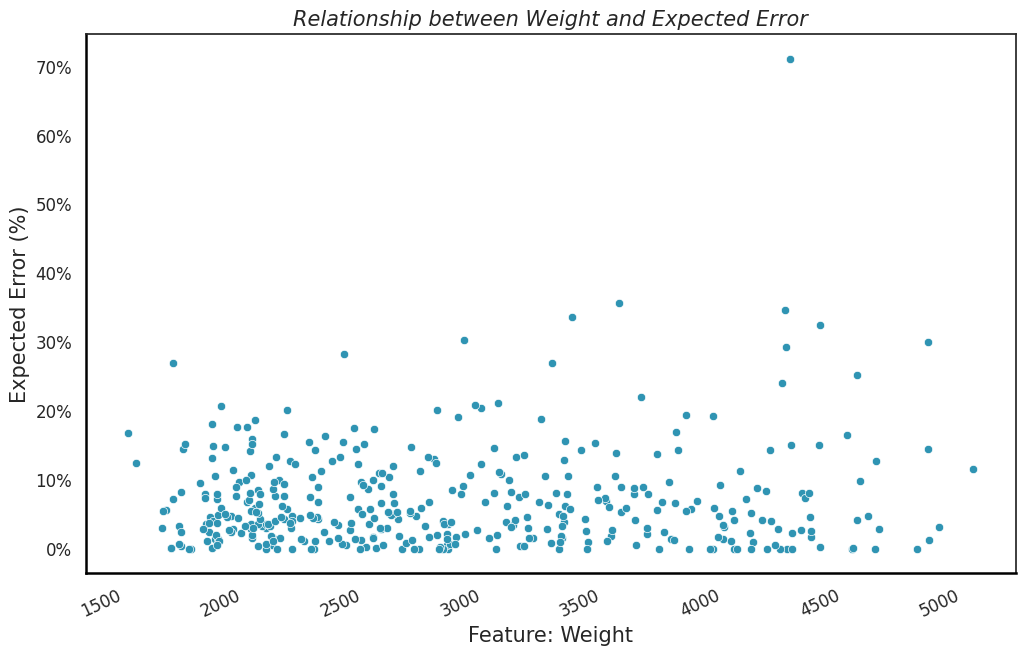

In [261]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(visible = False)
ax.set_facecolor("white")
sns.scatterplot(data = df, x = df["weight"], y = df["mape"], color = "#2F94B3") 
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
ax.yaxis.set_major_formatter(fmt_percent)
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="center", size=12) 
ax.set_yticklabels(ax.get_yticklabels(), size=12) 
plt.xlabel("Feature: Weight", size = 15) 
plt.ylabel("Expected Error (%)", size = 15)
plt.title("Relationship between Weight and Expected Error", size=15, style='italic')
plt.show()

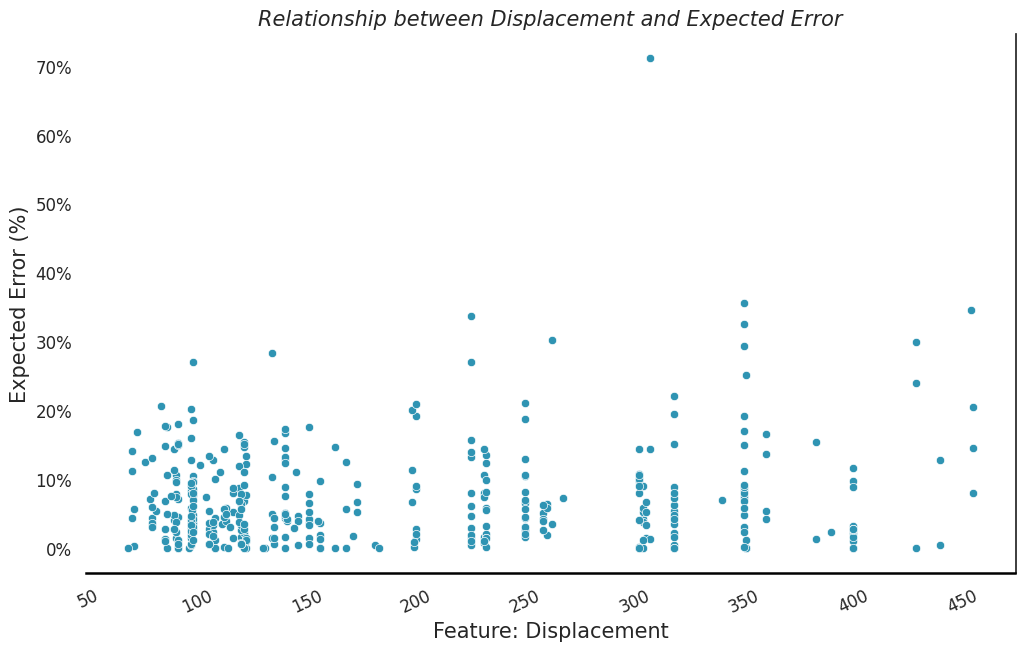

In [262]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(visible = False)
ax.set_facecolor("white")
sns.scatterplot(data = df, x = df["displacement"], y = df["mape"], color = "#2F94B3") 
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
ax.yaxis.set_major_formatter(fmt_percent)
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
plt.gca().spines['top'].set_linewidth(0) 
plt.gca().spines['left'].set_linewidth(0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="center", size=12) 
ax.set_yticklabels(ax.get_yticklabels(), size=12) 
plt.xlabel("Feature: Displacement", size = 15) 
plt.ylabel("Expected Error (%)", size = 15)
plt.title("Relationship between Displacement and Expected Error", size=15, style='italic')
plt.show()

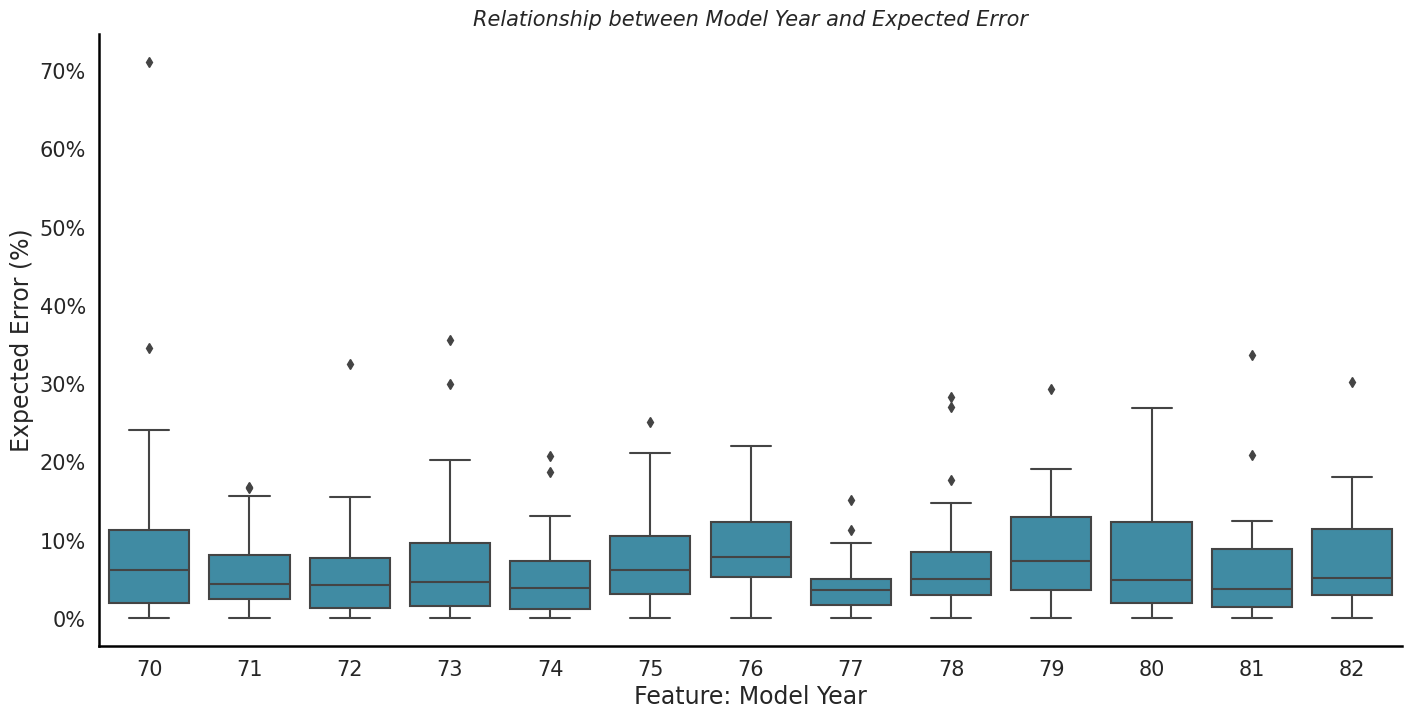

In [263]:
fig = sns.catplot(x="model year", y="mape", kind="box", data=df, height=7, aspect=2, color="#2F94B3")
fig.fig.set_facecolor('white')
fig.ax.grid(visible = False)
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
fig.ax.yaxis.set_major_formatter(fmt_percent)
fig.ax.tick_params(axis='both', which='major', labelsize=15)
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="center", size=12) 
ax.set_yticklabels(ax.get_yticklabels(), size=12) 
plt.xlabel("Feature: Model Year", fontdict={"size": 17}) 
plt.ylabel("Expected Error (%)", size = 17)
plt.title("Relationship between Model Year and Expected Error", size=15, style='italic')
plt.show()

# Model

## Performance benchmarking

In [264]:
# reload data for a fresh start
X_train = pd.read_csv('./regression_data/X_train.csv', sep=';', index_col=0)
y_train = pd.read_csv('./regression_data/y_train.csv', sep=';', index_col=0)
X_test = pd.read_csv('./regression_data/X_test.csv', sep=';', index_col=0)
y_test = pd.read_csv('./regression_data/y_test.csv', sep=';', index_col=0)
df = pd.read_csv('./regression_data/all_data.csv', sep=';', index_col=0)
model1 = joblib.load('./regression_data/lr_model1.joblib')

In [265]:
# properly encode output variables
y_name = 'mpg'
model_pred = 'model_pred'
df.rename(columns = {y_name:'Y', model_pred: 'model_pred'}, inplace = True)

In [266]:
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Y,model_pred
64,8,318.00,150,4135,13.50,72,1,15.00,14.19
55,4,97.00,60,1834,19.00,71,2,27.00,29.22
317,4,97.00,78,2188,15.80,80,2,34.30,33.28
102,4,97.00,46,1950,21.00,73,2,26.00,25.37
358,4,120.00,74,2635,18.30,81,3,31.60,32.12


In [267]:
# encode categorical output variable
to_category(df, 'origin', 'cylinders', 'model year', 'horsepower')
to_category(X_train, 'origin', 'cylinders', 'model year', 'horsepower')
column_encoder(X_train, df)# Apply same encoding to test and training data
column_encoder(X_test, X_train)

In [268]:
# eliminate weird values (specific to this dataset)
# eliminate weird values (specific to this dataset)

def remove_weird(df, val):
    id = df[df.isin([val]).any(1)].index
    df.drop(id, axis=0, inplace=True)

remove_weird(df, '?')
remove_weird(X_train, '?')
remove_weird(X_test, '?')

In [269]:
df.dropna(inplace=True)
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [270]:
y_train = y_train.loc[X_train.index,:]
y_test = y_test.loc[X_test.index, :]

In [271]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [272]:
# flatten output variables
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [273]:
# instantiate class for getting lazy models
lazy_class = LazyModelsReg()

# get lazy modesl and their predictions
models, predictions = lazy_class.get_models(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:07<00:00,  5.77it/s]


In [274]:
# Get top 3 models and their respective predictions
top_models, top_predictions = lazy_class.top_models(n=5)

In [275]:
top_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_percentage_error
Model,,,,,
LGBMRegressor,0.75,0.77,3.69,0.06,0.12
HistGradientBoostingRegressor,0.74,0.76,3.80,1.50,0.12
NuSVR,0.72,0.74,3.95,0.03,0.13
OrthogonalMatchingPursuit,0.71,0.74,3.96,0.02,0.15
SVR,0.71,0.73,4.01,0.02,0.13


In [276]:
calculate_residuals(df, df['Y'], df['model_pred'], task='R')

In [277]:
y_test_pred = model1.predict(X_test)

In [278]:
# calculate test mape
def res(y_true, y_pred):
        return y_true - y_pred

def mape_res(y_true, y_pred):
        return np.abs(res(y_true, y_pred)/y_true)

In [279]:
mape_test = mape_res(df_test["mpg"], y_test_pred)

## Auto parameter tuning

In [280]:
enc = fit_encoder(X_train)
X_train_scale = enc.transform(X_train)
X_test_scale = enc.transform(X_test)

### GBR

In [281]:
from sklearn.ensemble import GradientBoostingRegressor
# create model
model_gbr = GradientBoostingRegressor(random_state=2022)

# set bounds

pbounds_gbr = {"n_estimators": (10, 100),
                "max_depth": (1, 5),
                "learning_rate": (0.1, 1),
                "min_impurity_decrease": (0.01, 0.1)}

int_params_gbr = ["n_estimators", "max_depth"]

optimizer = ModelOptimizer(scoring="neg_root_mean_squared_error")
params_gbr = optimizer.optimize_model(pbounds=pbounds_gbr, X_train_scale=X_train_scale, 
                                      y_train=y_train, model=model_gbr, 
                                      int_params=int_params_gbr)

hyper_params = { (k):(int(np.round(v, 0)) if k in int_params_gbr else round(v, 2)) for k, v in params_gbr.items()}
gbr = model_gbr.set_params(**hyper_params)
gbr.fit(X_train_scale, y_train)

Best result: {'learning_rate': 0.10547879605006279, 'max_depth': 2.0, 'min_impurity_decrease': 0.07113843622391665, 'n_estimators': 72.0}.


GradientBoostingRegressor(learning_rate=0.11, max_depth=2,
                          min_impurity_decrease=0.07, n_estimators=72,
                          random_state=2022)

### Model metrics

In [282]:
y_train_pred = gbr.predict(X_train_scale)
y_test_pred = gbr.predict(X_test_scale)

In [283]:
global_metrics(y_train, y_train_pred, task="R")

MAE: 1.6593352146862952
Global MSE: 4.682838485387744
RMSE: 2.1639867110007267
R2: 0.9230249962687322
MAPE: 7.4220%


In [284]:
global_metrics(y_test, y_test_pred, task="R")

MAE: 2.0056087819503614
Global MSE: 7.823278652988423
RMSE: 2.7970124513466903
R2: 0.8702148720473615
MAPE: 8.6876%


# Model comparison

In [285]:
# plot these models against original model

names = ["Original Model", "LGBM", "HistGBR", "NuSVR", "OrthMatchPursuit", "SVR", "Tuned Model"]
mapes = [np.mean(mape_test)] + top_models.mean_absolute_percentage_error.tolist() + [0.086876]

In [286]:
model_comp_data = pd.DataFrame( {
    "names": names,
    "mapes": mapes
}
)

model_comp_ordered = model_comp_data.sort_values(["mapes"])

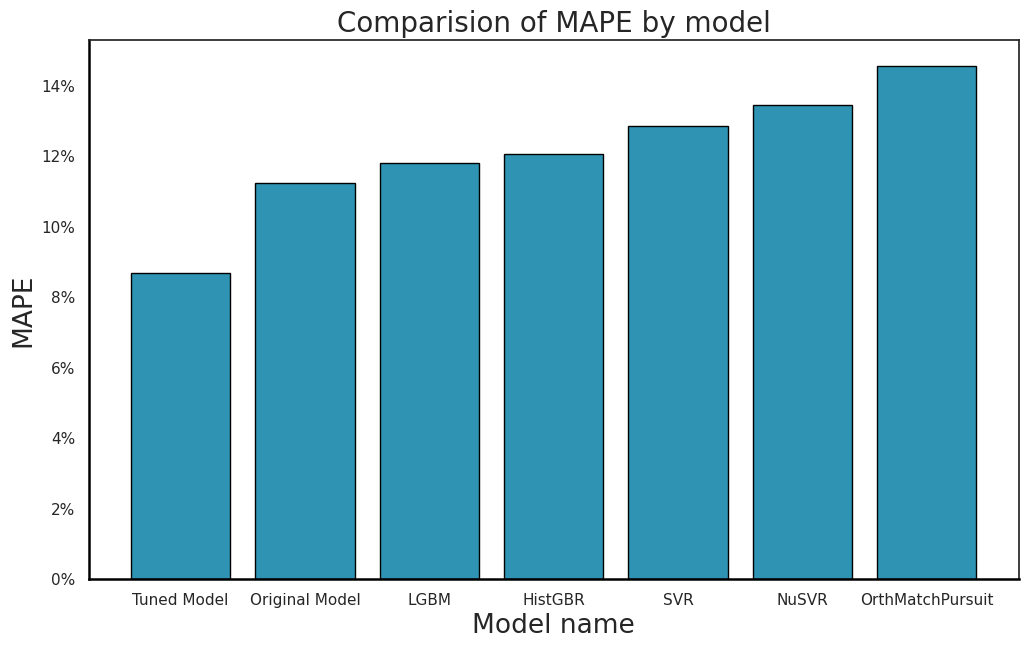

In [287]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(b=False)
ax.set_facecolor("white")
ax.bar("names", "mapes", data=model_comp_ordered, color="#2F94B3", edgecolor="black")
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
ax.yaxis.set_major_formatter(fmt_percent)
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
ax.set_xticklabels(ax.get_xticklabels()) 
plt.xlabel("Model name", size = 19) 
plt.ylabel("MAPE", size = 19)
plt.title('Comparision of MAPE by model', size=20)
plt.show()

# Data quality

## Features

### Feature interaction

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

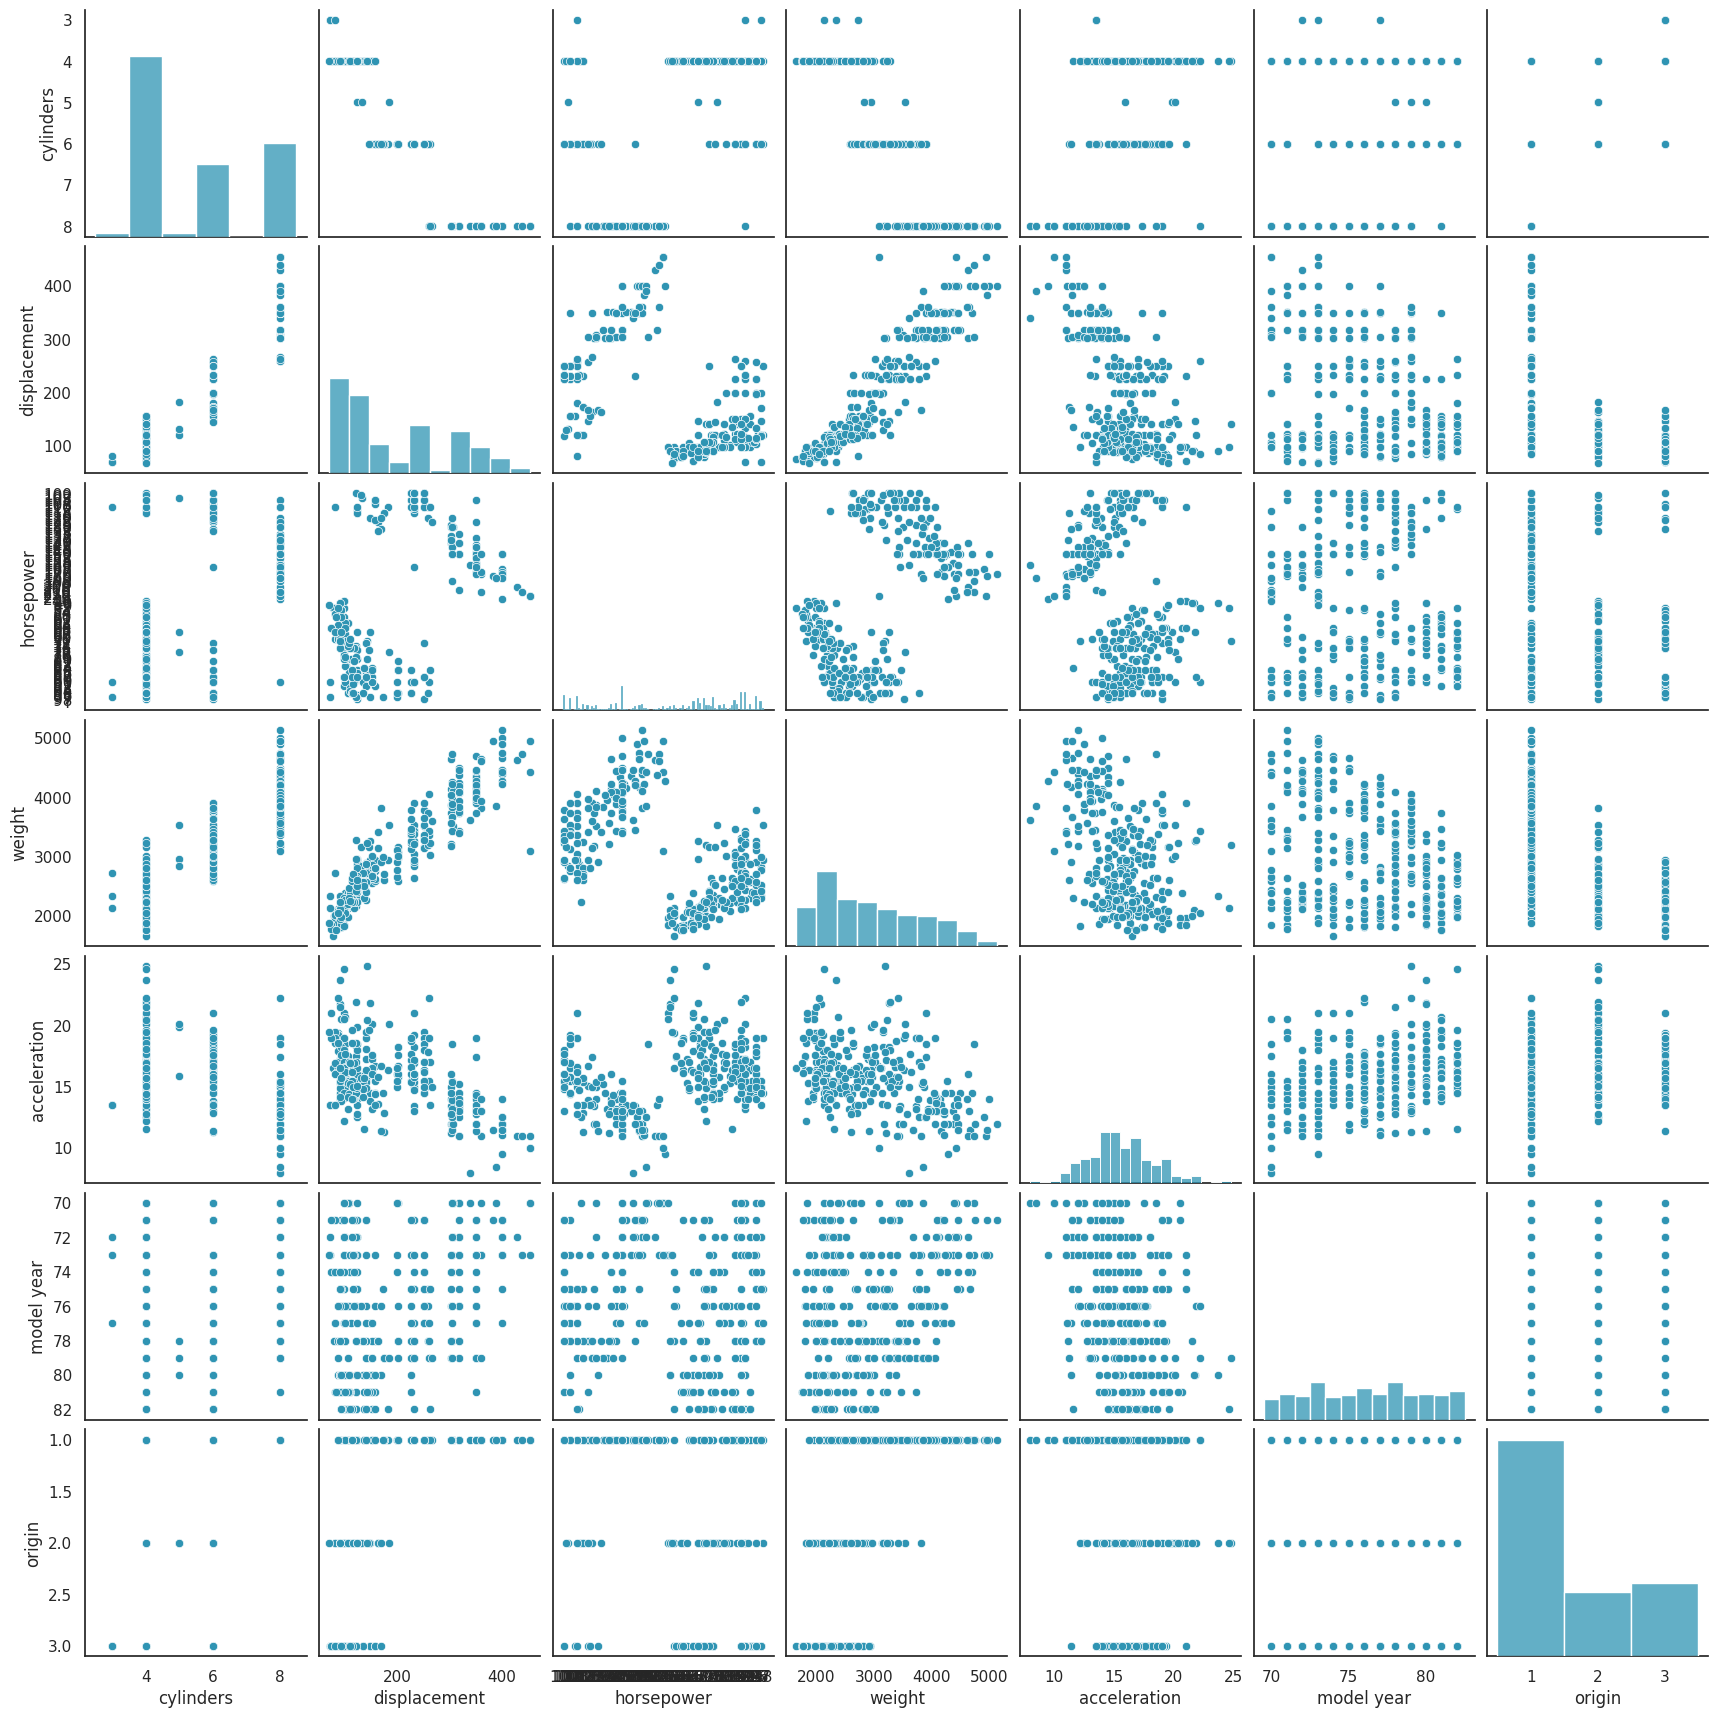

In [289]:
# Pairplot for visual inspection of variables
# NOTE: problems when dealing with cat data
new_palette = ["#2F94B3", "#2F94B3", "#2F94B3", "#2F94B3"]
sns.set_palette(new_palette)
sns.pairplot(X_train, vars=X_train.columns.values.tolist())
plt.show()

### Feature importance

In [290]:
# prepare data for SHAP
X_enc = model1['Prep'].transform(X_test)
# use explainer tool
explainer = SHAPEvaluator(X_enc=X_enc, model=model1[-1])

In [291]:
# Get feature importance
explainer.feature_importance()

,feature,importance
3,cylinders_4,2.88
6,cylinders_8,2.48
1,weight,2.16
5,cylinders_6,1.65
99,model year_82,0.86
...,...,...
29,horsepower_149,0.00
69,horsepower_79,0.00
27,horsepower_142,0.00
71,horsepower_81,0.00


In [292]:
# Get relevant plots
# explainer.summary_plot()

In [293]:
# feat_imp_table = explainer.feature_importance()
# explainer.plot_feature_importance(y=y_train)

### Feature correlation

In [294]:
vif_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
vif_cols

['displacement', 'weight', 'acceleration']

In [295]:
# Calculate VIF factor
X_proc = model1['Prep'].transform(X_train)
vif, vif_corr = calculate_VIF(X_proc)

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def corr_matrix(X_proc, features):
    """
    Function used for plotting correlation matrix

    INPUTS:
    -X_proc: pd.DataFrame
        Preprocessed data on which correlation matrix is to be plotted
    
    -features: list
        List of features for which the correlation matrix is to be 
        plotted. Only numerical features are allowed

    """
    sns.set()
    f = plt.figure()
    from matplotlib import colors
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    color1 = '#444444'
    color2 = '#92c5de'
    # color2 = '#2F94B3'
    # Create a custom colormap that is a gradient between the two colors
    cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], gamma=3.0, N=256)
    # cmap = sns.diverging_palette(h_pos=203.19, h_neg=26, n=256, as_cmap=True)
    corr = X_proc[features].corr()
    plt.matshow(corr, cmap=cmap, fignum=f.number)
    plt.grid(visible=False)
    plt.xticks(range(X_proc[features].shape[1]), X_proc[features].columns, fontsize=14, rotation=45, ha="left")
    plt.yticks(range(X_proc[features].shape[1]), X_proc[features].columns, fontsize=14)
    # cb = plt.colorbar()
    # cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)    
    plt.show()

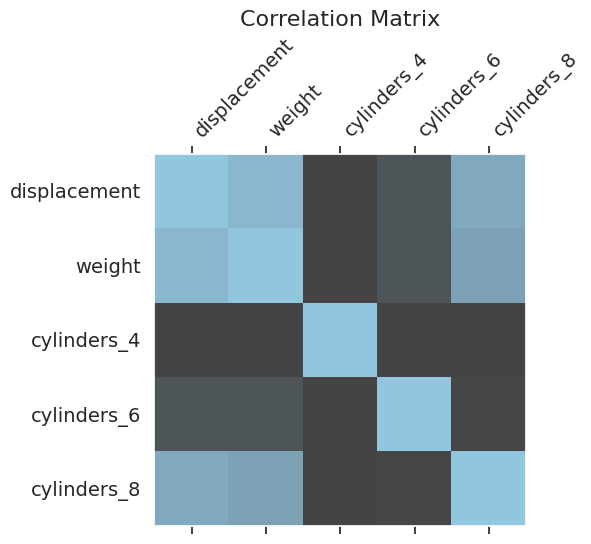

In [297]:
# Print correlation matrix desired features
corr_matrix(X_enc, features=vif_corr['features'])

## NAs

In [298]:
# load data from file
y_test = pd.read_csv('./regression_data/y_test.csv', sep=';', index_col=0)
y_test

,mpg
65,14.00
132,25.00
74,13.00
78,21.00
37,18.00
...,...
269,30.90
235,26.00
145,32.00
196,24.50


In [299]:
X_test.index

Int64Index([ 65, 132,  74,  78,  37,  54, 294,  60,  12, 341, 312, 100,  59,
            223, 295, 397, 372, 135, 304, 231, 170, 173,  76, 302, 361, 245,
            369, 342, 134, 260, 320, 154, 220, 363, 171, 176, 289, 293,  90,
              6,   1, 296, 334, 390, 122, 194, 212, 113, 142, 309, 141, 224,
             52,  10,  26,  45, 365, 391,   4, 200, 206, 107,  15, 106, 159,
              5, 153, 168,   7, 346,  68,  20, 199,  14, 269, 235, 145, 196,
            124],
           dtype='int64')

In [300]:
y_test = y_test.loc[X_test.index, :]

Estamos relacionando el número de NAs de las variables con el error del modelo. Por tanto, las X son el número de NAs de cada una de las variables y la Y es el error del modelo (en este caso, el MAPE). Luego le metemos un modelo de regresión lineal que nos diga la contribución de cada variable a la salida de error. Las variables con más valor del coeficiente tienen una mayor relación con la salida de error.

In [301]:
max_samples = int(np.ceil(1 * X_test.shape[0]))
y_true = y_test.reset_index(drop=True)

In [302]:
X_test

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
65,8,351.00,153,4129,13.00,72,1
132,4,140.00,75,2542,17.00,74,1
74,8,302.00,140,4294,16.00,72,1
78,4,120.00,87,2979,19.50,72,2
37,6,232.00,100,3288,15.50,71,1
...,...,...,...,...,...,...,...
269,4,105.00,75,2230,14.50,78,1
235,4,97.00,75,2265,18.20,77,3
145,4,83.00,61,2003,19.00,74,3
196,4,98.00,60,2164,22.10,76,1


In [303]:
# set max number of samples to convert to NAs
experiments_na = na_pipe(model1, X_test, 
                        y_true, max_samples, 
                        metric_func=mean_absolute_percentage_error, n_exp=1000)

### Linear regression

In [304]:
# preprocess experiments data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
n_cols = X_test.shape[1]
X_na = experiments_na[:, 0:n_cols]
y_na = experiments_na[:, -1]
scaler = StandardScaler()
X_na_scale = scaler.fit_transform(X_na)

# fit linear regression model
lr = LinearRegression()
lr.fit(X_na_scale, y_na)

LinearRegression()

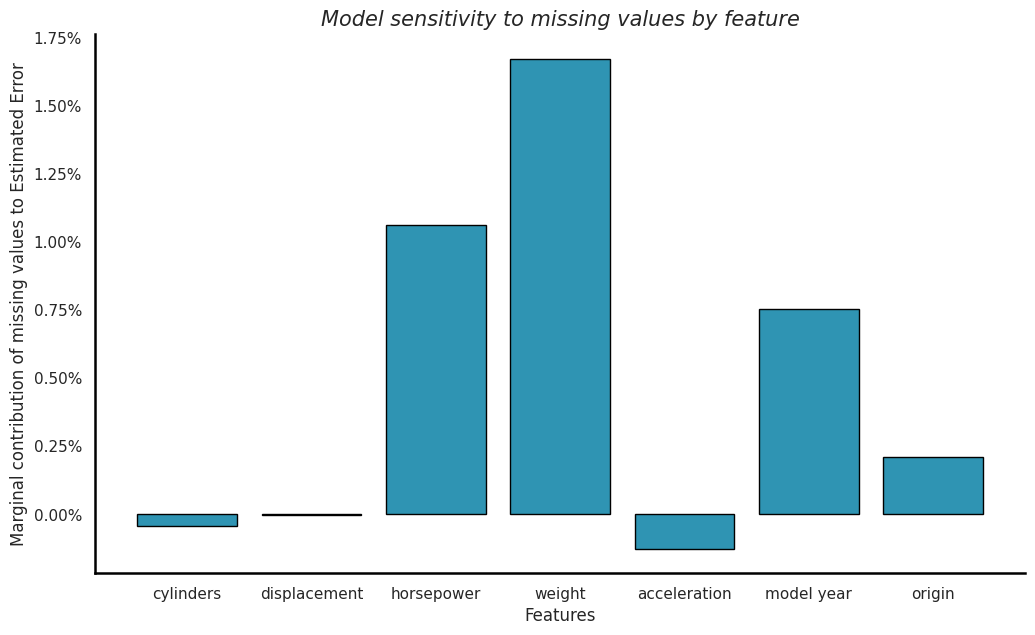

In [305]:
names = X_test.columns.tolist()
coefs = lr.coef_.tolist()

fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(visible=False)
ax.set_facecolor("white")
ax.bar(names, coefs, color="#2F94B3", edgecolor="black")
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
plt.gca().spines['top'].set_linewidth(0) 
plt.gca().spines['right'].set_linewidth(0) 
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=2)
ax.yaxis.set_major_formatter(fmt_percent)
ax.set_xticklabels(ax.get_xticklabels()) 
plt.xlabel("Features", size = 12) 
plt.ylabel("Marginal contribution of missing values to Estimated Error", size = 12)
plt.title('Model sensitivity to missing values by feature', size=15, style='italic')
plt.show()

Aquí vemos cómo afecta el porcentaje de NAs de cada una de las variables a la salida de error del modelo original

In [306]:
def features_pairplot(X_test, experiments, metric_name, n_cols): 
    cols = X_test.columns.values.tolist()
    cols.append(metric_name)
    vis_data = pd.DataFrame(experiments[:, n_cols:], columns=cols)
    sns.set_theme(style='white')
    from matplotlib.ticker import PercentFormatter
    g = sns.pairplot(vis_data, x_vars=vis_data.columns.values.tolist()[:-1], y_vars=metric_name,
                 kind="reg", plot_kws=dict(scatter = True, marker = '+', color = "black",
                 scatter_kws=dict(linewidths = 0.1, color = "#2F94B3")))
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    for ax in g.axes.flatten():
        ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
        ax.set_ylabel("Expected Error (%)", size=11)
        ax.set_xlabel(f"{ax.get_xlabel()}'s NA (%)", size=11)   

    plt.show()

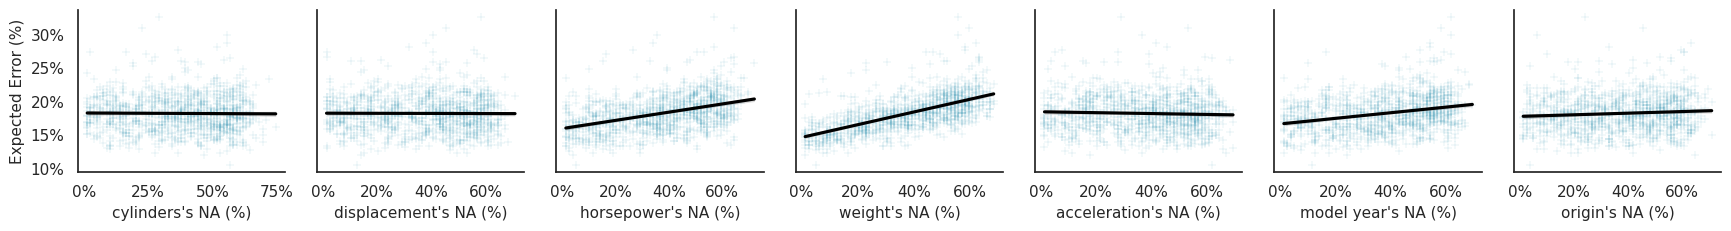

In [307]:
features_pairplot(X_test, experiments_na, "Expected Error (%)", n_cols)

## Outliers

In [308]:
experiments_out = outlier_pipe(model1, X_test, y_true, 
                               max_samples, metric_func=mean_absolute_percentage_error, 
                               n_exp=1000)

### Linear regression model

In [309]:
num_cols = X_test.select_dtypes(include=['int64','float64']).columns.tolist()
n_cols_out = len(num_cols)
X_out = experiments_out[:, 0:n_cols_out]
y_out = experiments_out[:, -1]

scaler = StandardScaler()
X_out_scale = scaler.fit_transform(X_out)
lr = LinearRegression()
lr.fit(X_out_scale, y_out)

LinearRegression()

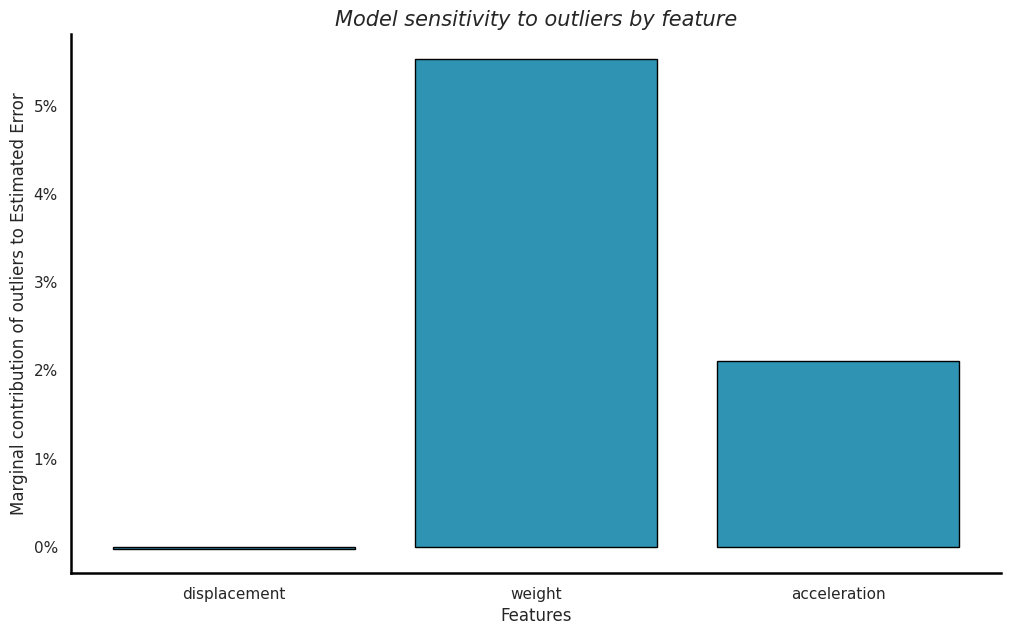

In [310]:
names = num_cols
coefs = lr.coef_.tolist()

fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(b=False)
ax.set_facecolor("white")
ax.bar(names, coefs, color="#2F94B3", edgecolor="black")
plt.gca().spines['bottom'].set_color('black') 
plt.gca().spines['left'].set_color('black') 
plt.gca().spines['left'].set_linewidth(1.8) 
plt.gca().spines['bottom'].set_linewidth(1.8) 
plt.gca().spines['top'].set_linewidth(0) 
plt.gca().spines['right'].set_linewidth(0) 
from matplotlib.ticker import PercentFormatter
fmt_percent = PercentFormatter(xmax=1.0, decimals=0)
ax.yaxis.set_major_formatter(fmt_percent)
ax.set_xticklabels(ax.get_xticklabels()) 
plt.xlabel("Features", size = 12) 
plt.ylabel("Marginal contribution of outliers to Estimated Error", size = 12)
plt.title('Model sensitivity to outliers by feature', size=15, style='italic')
plt.show()

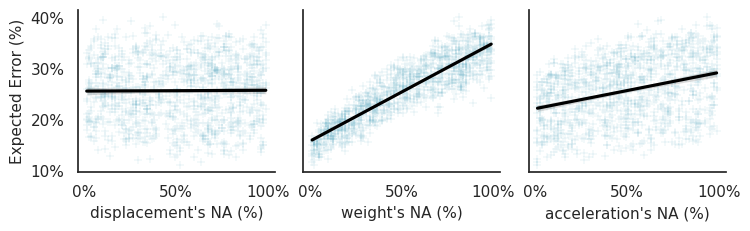

In [311]:
features_pairplot(X_test[num_cols], experiments_out, "MAPE", n_cols_out)

# Heatmap

## Categorical features

In [312]:
heatmap_df = df.groupby(["model year", "origin"])["mape"].mean().reset_index()

In [313]:
df_pivot = heatmap_df.pivot('model year', 'origin', 'mape')

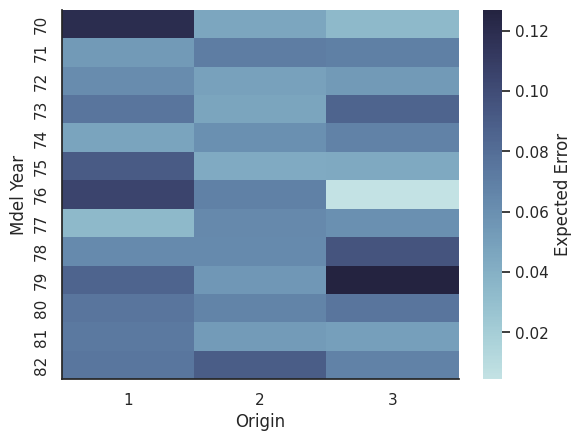

In [314]:
from matplotlib import colors
fig, ax = plt.subplots()
color1 = '#444444'
color2 = '#92c5de'
# color2 = '#2F94B3'
# Create a custom colormap that is a gradient between the two colors
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], N=10)
cmap = sns.color_palette("ch:start=.1,rot=-.25", as_cmap=True)
ax = sns.heatmap(df_pivot, cmap=cmap, cbar=True, cbar_kws={"label" : "Expected Error"})
sns.despine(ax=ax, top=True, right=True)
ax.set_xlabel("Origin")
ax.set_ylabel("Mdel Year")
plt.show()

## Numerical features

In [315]:
def to_discrete(df, vars, n_bins='auto'):
    """
    Function used to discretiza a given variable from a DataFrame
    
    INPUTS:
    
    - df: Pandas DataFrme
        the desired DataFrame containing the variable we wish to discretize

    - var: string
        name of the variable to discretize
    
    RETURNS:

    - df: Pandas DataFrame
        the modified DataFrame containing the binned variable
    """
    import pandas as pd
    import math
    df_discrete = df.copy()
    for var in vars:
        varname = '{}_binned'.format(var)

        if varname in df_discrete.columns:
            df_discrete.drop(varname, axis=1, inplace=True)

        if n_bins == 'auto':
            lower_edge, upper_edge = df_discrete[var].min(), df_discrete[var].max()
            n = len(df_discrete[var])
            size = math.ceil(2 * n**(1/3))
            n_bins = int(math.ceil(upper_edge - lower_edge) / size)
        else:
            pass
        
        var_binned = pd.cut(df_discrete[var], bins=n_bins, include_lowest=True, ordered=True, precision=2) # cut variable into intervals
        binned_col_position = df_discrete.columns.get_loc(var)+1
        
        df_discrete.insert(binned_col_position, varname, var_binned, 2)
    
    return df_discrete

In [140]:
df_discrete = to_discrete(df, vars=["mape", "model_pred"], n_bins=15)
df_discrete.head()

,cylinders,displacement,horsepower,weight,weight_binned,acceleration,acceleration_binned,model year,origin,Y,model_pred,res,abs_res,mape
64,8,318.00,150,4135,"(3964.33, 4199.47]",13.50,"(12.48, 13.6]",72,1,15.00,14.19,0.81,0.81,0.05
55,4,97.00,60,1834,"(1609.46, 1848.13]",19.00,"(18.08, 19.2]",71,2,27.00,29.22,-2.22,2.22,0.08
317,4,97.00,78,2188,"(2083.27, 2318.4]",15.80,"(14.72, 15.84]",80,2,34.30,33.28,1.02,1.02,0.03
102,4,97.00,46,1950,"(1848.13, 2083.27]",21.00,"(20.32, 21.44]",73,2,26.00,25.37,0.63,0.63,0.02
358,4,120.00,74,2635,"(2553.53, 2788.67]",18.30,"(18.08, 19.2]",81,3,31.60,32.12,-0.52,0.52,0.02


In [141]:
heatmap_df_2 = df_discrete.groupby(["weight_binned", "acceleration_binned"])["mape"].mean().reset_index()

In [142]:
df_pivot_2 = heatmap_df_2.pivot('weight_binned', 'acceleration_binned', 'mape')

In [143]:
df_pivot_2.head()

acceleration_binned,"(7.970000000000001, 9.12]","(9.12, 10.24]","(10.24, 11.36]","(11.36, 12.48]","(12.48, 13.6]","(13.6, 14.72]","(14.72, 15.84]","(15.84, 16.96]","(16.96, 18.08]","(18.08, 19.2]","(19.2, 20.32]","(20.32, 21.44]","(21.44, 22.56]","(22.56, 23.68]","(23.68, 24.8]"
weight_binned,,,,,,,,,,,,,,,
"(1609.46, 1848.13]",NaN,NaN,NaN,0.01,NaN,0.27,0.14,0.07,0.06,0.06,NaN,0.01,NaN,NaN,NaN
"(1848.13, 2083.27]",NaN,NaN,NaN,NaN,NaN,0.08,0.08,0.04,0.08,0.10,0.03,0.03,0.03,NaN,NaN
"(2083.27, 2318.4]",NaN,NaN,NaN,0.03,0.06,0.06,0.06,0.06,0.07,0.12,NaN,NaN,0.05,0.05,0.16
"(2318.4, 2553.53]",NaN,NaN,NaN,NaN,0.09,0.02,0.10,0.01,0.09,0.04,0.07,0.10,NaN,NaN,0.01
"(2553.53, 2788.67]",NaN,NaN,0.09,NaN,0.10,0.05,0.05,0.03,0.11,0.04,0.06,NaN,NaN,NaN,NaN


In [144]:
len(df_pivot_2.columns.tolist())

15

### Original heatmap

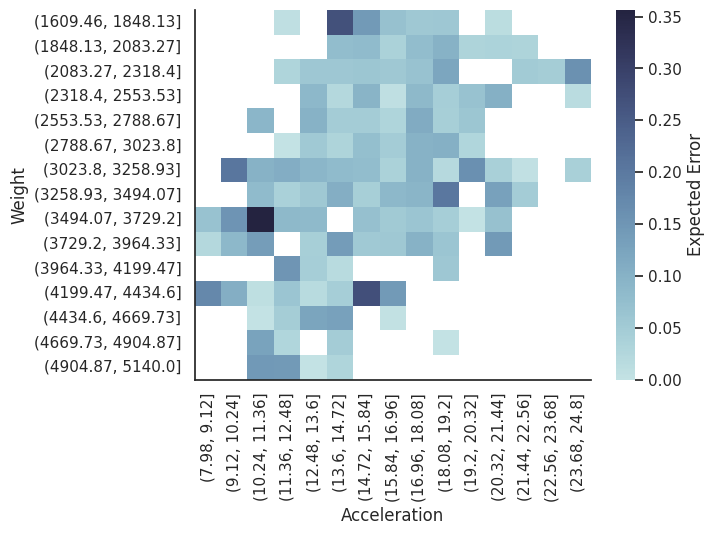

In [145]:
from matplotlib import colors
fig, ax = plt.subplots()
color1 = '#444444'
color2 = '#92c5de'
# color2 = '#2F94B3'
# Create a custom colormap that is a gradient between the two colors
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], N=10)
cmap = sns.color_palette("ch:start=.1,rot=-.25", as_cmap=True)
ax = sns.heatmap(df_pivot_2, cmap=cmap, cbar=True, cbar_kws={"label" : "Expected Error"})
sns.despine(ax=ax, top=True, right=True)
# ax.set_yticklabels(df_pivot_2.index.tolist(), rotation=0)
# ax.set_xticklabels(df_pivot_2.columns.tolist(), rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '(7.98, 9.12]'
ax.set_xticklabels(labels)
ax.set_xlabel("Acceleration")
ax.set_ylabel("Weight")
plt.show()

### Simple Imputation

In [146]:
from sklearn.impute import SimpleImputer

fill_value = np.percentile(heatmap_df_2["mape"].dropna(), 80)

simple_imputer = SimpleImputer(strategy="constant", fill_value=fill_value)

df_pivot_impute = simple_imputer.fit_transform(df_pivot_2)

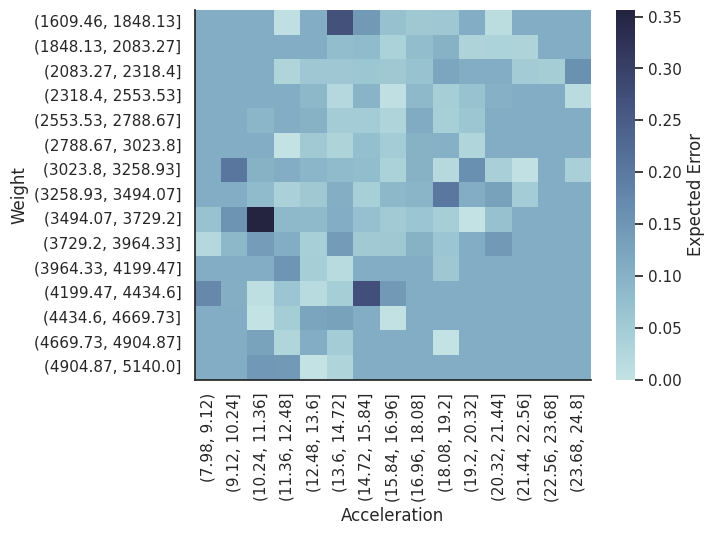

In [147]:
from matplotlib import colors
fig, ax = plt.subplots()
color1 = '#444444'
color2 = '#92c5de'
# color2 = '#2F94B3'
# Create a custom colormap that is a gradient between the two colors
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], N=10)
cmap = sns.color_palette("ch:start=.1,rot=-.25", as_cmap=True)
ax = sns.heatmap(df_pivot_impute, cmap=cmap, cbar=True, cbar_kws={"label" : "Expected Error"})
sns.despine(ax=ax, top=True, right=True)
ax.set_yticklabels(df_pivot_2.index.tolist(), rotation=0)
ax.set_xticklabels(df_pivot_2.columns.tolist(), rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '(7.98, 9.12)'
ax.set_xticklabels(labels)
ax.set_xlabel("Acceleration")
ax.set_ylabel("Weight")
plt.show()

### Iterative Imputer

In [148]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
df_pivot_iter = iterative_imputer.fit_transform(df_pivot_2)

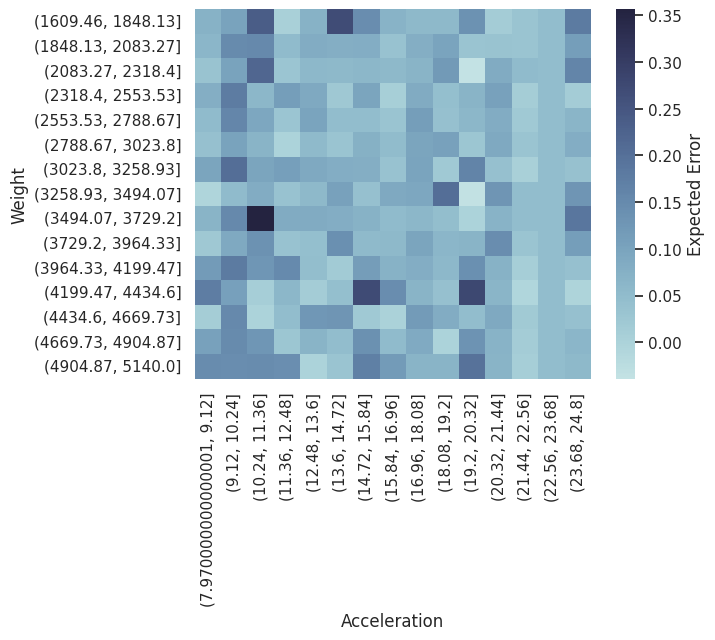

In [149]:
from matplotlib import colors
fig, ax = plt.subplots()
color1 = '#444444'
color2 = '#92c5de'
# color2 = '#2F94B3'
# Create a custom colormap that is a gradient between the two colors
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], N=10)
cmap = sns.color_palette("ch:start=.1,rot=-.25", as_cmap=True)
ax = sns.heatmap(df_pivot_iter, cmap=cmap, cbar=True, cbar_kws={"label" : "Expected Error"})
ax.set_yticklabels(df_pivot_2.index.tolist(), rotation=0)
ax.set_xticklabels(df_pivot_2.columns.tolist(), rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel("Acceleration")
ax.set_ylabel("Weight")
plt.show()

### KNNImputation

In [150]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=4, weights='uniform', metric='nan_euclidean')
knn_imputer.fit(df_pivot_2)

df_pivot_knn = knn_imputer.transform(df_pivot_2)

In [165]:
df_pivot_2.columns.tolist()[0].left

7.970000000000001

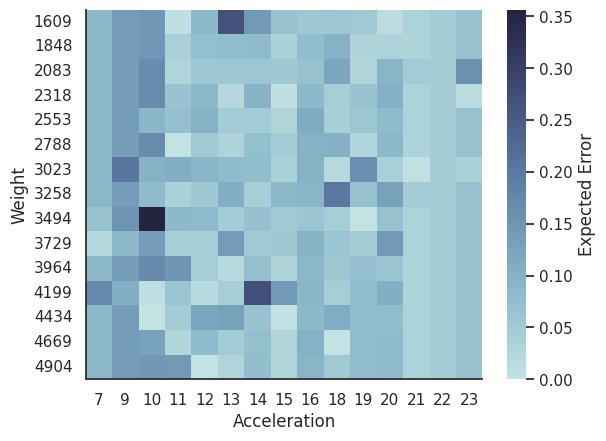

In [167]:
from matplotlib import colors
fig, ax = plt.subplots()
color1 = '#444444'
color2 = '#92c5de'
# color2 = '#2F94B3'
# Create a custom colormap that is a gradient between the two colors
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, color1), (1, color2)], N=10)
cmap = sns.color_palette("ch:start=.1,rot=-.25", as_cmap=True)
ax = sns.heatmap(df_pivot_knn, cmap=cmap, cbar=True, cbar_kws={"label" : "Expected Error"})
sns.despine(ax=ax, top=True, right=True)
x_labels = [int(id.left) for id in df_pivot_2.index.tolist()]
y_labels = [int(id.left) for id in df_pivot_2.columns.tolist()]
ax.set_yticklabels(x_labels, rotation=0)
ax.set_xticklabels(y_labels)
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[0] = '(7.98, 9.12)'
# ax.set_xticklabels(labels)
ax.set_xlabel("Acceleration")
ax.set_ylabel("Weight")
plt.show()